Ethical AI Decision-Making: Trolley Problem Simulation

This project explores whether an AI model can replicate or simulate human ethical decision-making in trolley problem scenarios, based on real-world response data.

In [2]:
##1. Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import shap
import joblib

In [4]:
##2. Load and Preview the Data

In [5]:
df = pd.read_csv(r"C:\Users\iPC\College ML Project\AI trolley problem\Shared_data_allResponses.csv")
df.head()

,_id,Scenario,UserID,Outcome,Session_id,Scenario_order,Template,answerLeft,lang,seenOther,country_code,country_full
0,wkZZprg4iwQKjrqvc,Loop,48f1bb65_4565879731077689,1,1767950778-4.56587973108e+15,1,Desktop,False,en,False,US,United States
1,Ae2DiwWXkTDa5ErRG,Footbridge,48f1bb65_4565879731077689,0,1767950778-4.56587973108e+15,2,Desktop,False,en,False,US,United States
2,oZicKrdCz4n8RDGSY,Switch,48f1bb65_4565879731077689,1,1767950778-4.56587973108e+15,3,Desktop,True,en,False,US,United States
3,6B9Dq4yZTCgLiXWDe,Switch,7c4c2a1c_462860651624685,1,-1211112355-4.62860651625e+14,1,Desktop,False,pt,True,BR,Brazil
4,2v8wSKWNRaW4Yn2dj,Footbridge,7621728d_1803646896188107,0,-1928670721-1.80364689619e+15,1,Desktop,False,en,True,US,United States


In [6]:
## 3. Preprocessing

#We encode categorical variables and select relevant features for training.

In [7]:
# Encode categorical variables
df_clean = df.copy()

df_clean['Scenario'] = df_clean['Scenario'].astype('category').cat.codes
df_clean['lang'] = df_clean['lang'].astype('category').cat.codes
df_clean['country_code'] = df_clean['country_code'].astype('category').cat.codes
df_clean['Template'] = df_clean['Template'].astype('category').cat.codes

# Select features and label
features = ['Scenario', 'answerLeft', 'seenOther', 'lang', 'country_code', 'Template']
X = df_clean[features]
y = df_clean['Outcome']

## 4. Train the Model


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [10]:
## 5. Evaluate the Model

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.15      0.23     13927
           1       0.72      0.94      0.82     32168

    accuracy                           0.70     46095
   macro avg       0.63      0.55      0.53     46095
weighted avg       0.66      0.70      0.64     46095



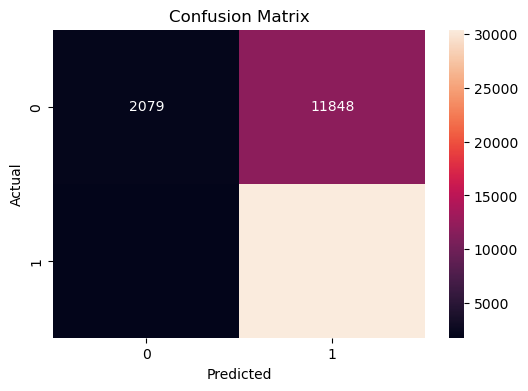

In [11]:
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 6. Explainability with SHAP (Optional)
#
This helps us understand which features most influenced the AI's decisio.


<Figure size 640x480 with 0 Axes>

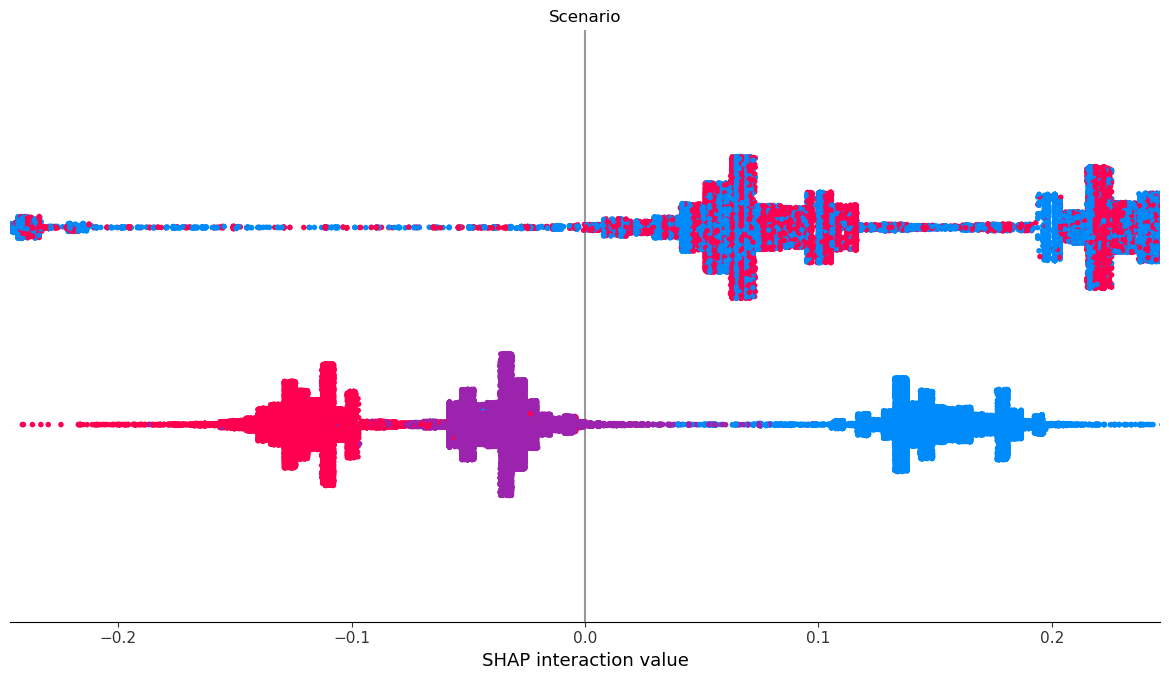

In [13]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

## 7. Simulate New Scenarios
#
We define a function that lets us simulate how the AI would decide in different ethical scenario.


In [15]:
def simulate_scenario(model, scenario_name, answer_left, seen_other, lang_str, country_str, device_str):
    scenario_map = {'Footbridge': 0, 'Loop': 1, 'Switch': 2}
    lang_map = {'en': 0, 'pt': 1, 'es': 2, 'de': 3, 'hi': 4}
    country_map = {'US': 0, 'BR': 1, 'ES': 2, 'IN': 3, 'DE': 4}

    device_map = {
        'Desktop': 0,
        'Mobile': 1
    }
    scenario_explainer = {
        'Footbridge': "You must decide whether to push a person off a bridge to stop a trolley and save five people.",
        'Loop': "A trolley will hit five people unless diverted, but doing so causes one person to be hit instead.",
        'Switch': "You can flip a switch to divert a trolley from five people onto a track with one person."
    }
    input_df = pd.DataFrame([{
        'Scenario': scenario_map.get(scenario_name, 0),
        'answerLeft': answer_left,
        'seenOther': seen_other,
        'lang': lang_map.get(lang_str, 0),
        'country_code': country_map.get(country_str, 0),
        'Template': device_map.get(device_str, 0)
    }])
    prediction = model.predict(input_df)[0]
    decision_text = (
        "✅ Take action to save more people (e.g., push/flip the switch)." 
        if prediction == 1 
        else "🛑 Do nothing (avoid causing direct harm)."
    )
    print("------------------------------------------------------")
    print(f"🧪 Scenario: {scenario_name}")
    print(f"📖 Description: {scenario_explainer.get(scenario_name, 'N/A')}")
    print(f"🌍 Country: {country_str}, Language: {lang_str}, Device: {device_str}")
    print(f"🧠 AI Ethical Decision: {decision_text}")
    print("------------------------------------------------------")
    return decision_text

In [16]:
simulate_scenario(model, 'Loop', True, False, 'pt', 'BR', 'Desktop')
simulate_scenario(model, 'Switch', False, True, 'en', 'US', 'Mobile')


------------------------------------------------------
🧪 Scenario: Loop
📖 Description: A trolley will hit five people unless diverted, but doing so causes one person to be hit instead.
🌍 Country: BR, Language: pt, Device: Desktop
🧠 AI Ethical Decision: ✅ Take action to save more people (e.g., push/flip the switch).
------------------------------------------------------
------------------------------------------------------
🧪 Scenario: Switch
📖 Description: You can flip a switch to divert a trolley from five people onto a track with one person.
🌍 Country: US, Language: en, Device: Mobile
🧠 AI Ethical Decision: ✅ Take action to save more people (e.g., push/flip the switch).
------------------------------------------------------


'✅ Take action to save more people (e.g., push/flip the switch).'

In [17]:
## 8. Save the model

In [19]:
joblib.dump(model, "decision_model.pkl")

['decision_model.pkl']

Conclusion

This project demonstrates that:
- Ethical decision-making patterns can be learned by AI
- Cultural and contextual factors influence choices
- AI can simulate human-like ethical judgments, raising important philosophical questions about autonomy and fairness